In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка и предобработка данных

## Classification dataset (bank)

In [4]:
df_c = pd.read_csv('../data/bank_additional_preprocessed.csv', sep=';')

In [5]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   pdays                          41188 non-null  int64  
 3   emp.var.rate                   41188 non-null  float64
 4   cons.price.idx                 41188 non-null  float64
 5   cons.conf.idx                  41188 non-null  float64
 6   euribor3m                      41188 non-null  float64
 7   nr.employed                    41188 non-null  float64
 8   y                              41188 non-null  int64  
 9   job_admin.                     41188 non-null  int64  
 10  job_blue-collar                41188 non-null  int64  
 11  job_entrepreneur               41188 non-null  int64  
 12  job_housemaid                  41188 non-null 

### Разделим данные на обучение и тест, нормализуем их

In [6]:
X_c = df_c.drop('y', axis=1)
y_c = df_c.y

Для удобства обработки разделим признаки на категориальные и вещественные

In [7]:
numeric_cols_c = np.array(['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 
           'cons.conf.idx', 'euribor3m', 'nr.employed'])
X_numeric_c = X_c[numeric_cols_c]

In [8]:
categorical_cols_c = list(set(X_c.columns.values.tolist()) - set(numeric_cols_c))
X_categorical_c = X_c[categorical_cols_c]
for col in categorical_cols_c:
    X_categorical_c[col] = X_categorical_c[col].astype('int')

<ipython-input-8-2a7e3699dc77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_categorical_c[col] = X_categorical_c[col].astype('int')


In [9]:
print(X_categorical_c.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   month_apr                      41188 non-null  int32
 1   month_oct                      41188 non-null  int32
 2   housing_no                     41188 non-null  int32
 3   marital_divorced               41188 non-null  int32
 4   previous_1                     41188 non-null  int32
 5   education_basic.4y             41188 non-null  int32
 6   default_yes                    41188 non-null  int32
 7   poutcome_nonexistent           41188 non-null  int32
 8   job_housemaid                  41188 non-null  int32
 9   job_student                    41188 non-null  int32
 10  education_illiterate           41188 non-null  int32
 11  job_blue-collar                41188 non-null  int32
 12  marital_single                 41188 non-null  int32
 13  job_admin.      

Разделим данные на обучение и тест

In [10]:
X_train_c, X_test_c, X_train_cat_c, X_test_cat_c, X_train_num_c, X_test_num_c, y_train_c, y_test_c = train_test_split(X_c, X_categorical_c, X_numeric_c, y_c, test_size=0.25, stratify=y_c)
y_train = y_train_c.values
y_test = y_test_c.values

Нормализируем значения

In [11]:
scaler = StandardScaler()
scaler.fit(X_train_num_c)

X_train_num_sc_c = scaler.transform(X_train_num_c)
X_test_num_sc_c = scaler.transform(X_test_num_c)

Соединяем воедино все значения

In [12]:
X_train_transform_c = np.hstack((X_train_num_sc_c, X_train_cat_c))
X_test_transform_c = np.hstack((X_test_num_sc_c, X_test_cat_c))

X_train = X_train_transform_c
X_test = X_test_transform_c

# Обучение нейронной сети

Определим функции подсчета функции ошибки для классификации

In [13]:
def print_score(y_true, y_pred):
    print('R^2: {}'.format(metrics.r2_score(y_true, y_pred)))
    print('f1: {}'.format(metrics.f1_score(y_true, y_pred, average=None)))
    print('MSE: {}'.format(metrics.mean_squared_error(y_true, y_pred)))
    print('RMSE: {}'.format(metrics.mean_squared_error(y_true, y_pred, squared=False)))
    print('MAE: {}'.format(metrics.mean_absolute_error(y_true, y_pred)))

Определим функции активации на слоях - будем подбирать лучшую, как гиперпараметр

In [14]:
activation_alias = [
    'relu',
    'sigmoid',
    'softmax',
    'softplus',
    'softsign',
    'tanh',
    'selu',
    'elu',
    'exponential',
]

## Classification

### Подбор гиперпараметров - функция активации

In [15]:
print(len(X_train.shape), len(y_train.shape))

2 1


In [16]:
best_last_error = np.inf
best_alg = activation_alias[0]
h_best = []
h_activation = {}

for activate in activation_alias:
    model = Sequential()
    model.add(Dense(2, input_dim=X_train.shape[1], activation=activate))
    model.add(Dense(2, activation=activate))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('Algorytm: {}', activate)
    %time history = model.fit(X_train, y_train, batch_size=int(X_train.shape[0] / 10), epochs=100).history['loss']
    print()
    h_activation[activate] = history
    last_error = history[-1]
    if best_last_error > last_error:
        best_last_error = last_error
        best_alg = activate
        h_best = history

Algorytm: {} relu
Epoch 1/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6341 - accuracy: 0.8861
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6044 - accuracy: 0.8869
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5778 - accuracy: 0.8865
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.8884
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5121 - accuracy: 0.8887
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4804 - accuracy: 0.8872
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4485 - accuracy: 0.8872
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.8847
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.8870
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3892 - accuracy

11/11 [==============================] - 0s 2ms/step - loss: 0.2858 - accuracy: 0.8861
Epoch 83/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2816 - accuracy: 0.8889
Epoch 84/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2816 - accuracy: 0.8875
Epoch 85/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2836 - accuracy: 0.8866
Epoch 86/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2821 - accuracy: 0.8869
Epoch 87/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2847 - accuracy: 0.8862
Epoch 88/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.8873
Epoch 89/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2867 - accuracy: 0.8862
Epoch 90/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2859 - accuracy: 0.8868
Epoch 91/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2835 - accuracy: 0.8863
Epoch 92/100


11/11 [==============================] - 0s 2ms/step - loss: 0.3992 - accuracy: 0.8886
Epoch 64/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3993 - accuracy: 0.8860
Epoch 65/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3953 - accuracy: 0.8873
Epoch 66/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3928 - accuracy: 0.8873
Epoch 67/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3891 - accuracy: 0.8883
Epoch 68/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.8875
Epoch 69/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3857 - accuracy: 0.8885
Epoch 70/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3857 - accuracy: 0.8874
Epoch 71/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3824 - accuracy: 0.8885
Epoch 72/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3812 - accuracy: 0.8879
Epoch 73/100


11/11 [==============================] - 0s 2ms/step - loss: 0.3436 - accuracy: 0.8888
Epoch 45/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3441 - accuracy: 0.8875
Epoch 46/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3466 - accuracy: 0.8856
Epoch 47/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3464 - accuracy: 0.8850
Epoch 48/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.8895
Epoch 49/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3405 - accuracy: 0.8876
Epoch 50/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3425 - accuracy: 0.8861
Epoch 51/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3442 - accuracy: 0.8849
Epoch 52/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3361 - accuracy: 0.8891
Epoch 53/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3403 - accuracy: 0.8860
Epoch 54/100


11/11 [==============================] - 0s 2ms/step - loss: 0.5355 - accuracy: 0.8861
Epoch 26/100
11/11 [==============================] - 0s 1ms/step - loss: 0.5222 - accuracy: 0.8900
Epoch 27/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5122 - accuracy: 0.8864
Epoch 28/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5010 - accuracy: 0.8870
Epoch 29/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4899 - accuracy: 0.8871
Epoch 30/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4799 - accuracy: 0.8864
Epoch 31/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4702 - accuracy: 0.8857
Epoch 32/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4604 - accuracy: 0.8858
Epoch 33/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4492 - accuracy: 0.8881
Epoch 34/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4412 - accuracy: 0.8868
Epoch 35/100


11/11 [==============================] - 0s 1ms/step - loss: 0.4924 - accuracy: 0.8734
Epoch 7/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4733 - accuracy: 0.8819
Epoch 8/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4569 - accuracy: 0.8857
Epoch 9/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4450 - accuracy: 0.8856
Epoch 10/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.8856
Epoch 11/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4218 - accuracy: 0.8867
Epoch 12/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4136 - accuracy: 0.8869
Epoch 13/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4051 - accuracy: 0.8869
Epoch 14/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3951 - accuracy: 0.8906
Epoch 15/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3899 - accuracy: 0.8903
Epoch 16/100
11/

11/11 [==============================] - 0s 2ms/step - loss: 0.2927 - accuracy: 0.8931
Epoch 89/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2900 - accuracy: 0.8950
Epoch 90/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2914 - accuracy: 0.8949
Epoch 91/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2906 - accuracy: 0.8953
Epoch 92/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2911 - accuracy: 0.8944
Epoch 93/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2884 - accuracy: 0.8966
Epoch 94/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2908 - accuracy: 0.8950
Epoch 95/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2891 - accuracy: 0.8954
Epoch 96/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2905 - accuracy: 0.8941
Epoch 97/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2922 - accuracy: 0.8937
Epoch 98/100


11/11 [==============================] - 0s 1ms/step - loss: 0.2896 - accuracy: 0.8945
Epoch 70/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2864 - accuracy: 0.8967
Epoch 71/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2894 - accuracy: 0.8947
Epoch 72/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2878 - accuracy: 0.8952
Epoch 73/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2902 - accuracy: 0.8951
Epoch 74/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2873 - accuracy: 0.8953
Epoch 75/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2877 - accuracy: 0.8954
Epoch 76/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2855 - accuracy: 0.8963
Epoch 77/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2884 - accuracy: 0.8952
Epoch 78/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2848 - accuracy: 0.8974
Epoch 79/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2879 - accuracy: 0.8960
Epoch 51/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2870 - accuracy: 0.8973
Epoch 52/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2881 - accuracy: 0.8965
Epoch 53/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2852 - accuracy: 0.8979
Epoch 54/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2850 - accuracy: 0.8975
Epoch 55/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2864 - accuracy: 0.8970
Epoch 56/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2855 - accuracy: 0.8976
Epoch 57/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2904 - accuracy: 0.8937
Epoch 58/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2867 - accuracy: 0.8974
Epoch 59/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2852 - accuracy: 0.8970
Epoch 60/100


11/11 [==============================] - 0s 1ms/step - loss: 0.3038 - accuracy: 0.8975
Epoch 32/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3072 - accuracy: 0.8964
Epoch 33/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.8965
Epoch 34/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3068 - accuracy: 0.8955
Epoch 35/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3064 - accuracy: 0.8955
Epoch 36/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3004 - accuracy: 0.8980
Epoch 37/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3016 - accuracy: 0.8970
Epoch 38/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3002 - accuracy: 0.8967
Epoch 39/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2991 - accuracy: 0.8965
Epoch 40/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3005 - accuracy: 0.8952
Epoch 41/100


11/11 [==============================] - 0s 1ms/step - loss: 0.3264 - accuracy: 0.8890
Epoch 13/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3279 - accuracy: 0.8864
Epoch 14/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3266 - accuracy: 0.8880
Epoch 15/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3254 - accuracy: 0.8863
Epoch 16/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3277 - accuracy: 0.8852
Epoch 17/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3256 - accuracy: 0.8859
Epoch 18/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3158 - accuracy: 0.8895
Epoch 19/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3190 - accuracy: 0.8880
Epoch 20/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3220 - accuracy: 0.8866
Epoch 21/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3178 - accuracy: 0.8875
Epoch 22/100


11/11 [==============================] - 0s 1ms/step - loss: 0.2831 - accuracy: 0.8989
Epoch 95/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2821 - accuracy: 0.8986
Epoch 96/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2781 - accuracy: 0.9006
Epoch 97/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2808 - accuracy: 0.8997
Epoch 98/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2822 - accuracy: 0.8974
Epoch 99/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2810 - accuracy: 0.8989
Epoch 100/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2810 - accuracy: 0.8976
Wall time: 2.08 s



Выведем лучшие параметры

In [17]:
best_last_error

0.2804219424724579

In [18]:
best_alg

'exponential'

В первый проход был получен softsign - дальнейшие вычисления идут именно с ним

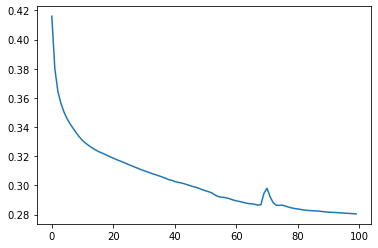

In [19]:
plt.plot(h_best)

Визуализируем данные на различных функциях активации

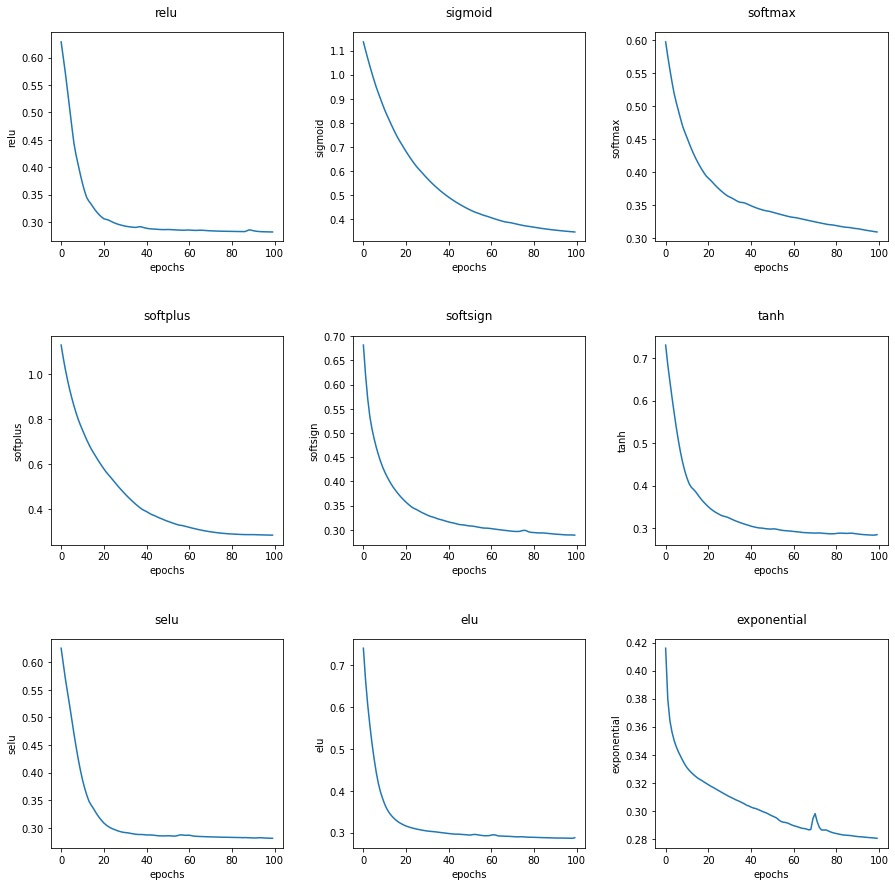

In [22]:
fig, axes = plt.subplots(nrows=(len(h_activation) + 2)//3, ncols=3, figsize=(15, 15))
axes = axes.reshape(3 * ((len(h_activation) + 2)//3))

for i, activate in enumerate(h_activation):
    axes[i].plot(range(len(h_activation[activate])), h_activation[activate])
    axes[i].set_xlabel('epochs')
    axes[i].set_ylabel(activate)
    axes[i].set_title(activate, pad=16)
# Увелчиваем расстояние между графиками
plt.subplots_adjust(wspace=0.3, hspace=0.45)

Будем тренировать модель на функции активации softsign

In [23]:
model_best = Sequential()
model_best.add(Dense(2, input_dim=X_train.shape[1], activation='softsign'))
model_best.add(Dense(2, activation='softsign'))
model_best.add(Dense(2, activation='softmax'))

model_best.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Algorytm: {}', best_alg)
%time history = model_best.fit(X_train, y_train, epochs=1000).history['loss']
error = history[-1]

y_pred = np.argmax(model_best.predict(X_test), axis=1)
print_score(y_test, y_pred)

Algorytm: {} exponential
Epoch 1/1000
966/966 [==============================] - 1s 549us/step - loss: 0.3844 - accuracy: 0.8742
Epoch 2/1000
966/966 [==============================] - 1s 588us/step - loss: 0.2868 - accuracy: 0.8942
Epoch 3/1000
966/966 [==============================] - 1s 568us/step - loss: 0.2812 - accuracy: 0.8956
Epoch 4/1000
966/966 [==============================] - 1s 698us/step - loss: 0.2750 - accuracy: 0.8993
Epoch 5/1000
966/966 [==============================] - 1s 576us/step - loss: 0.2813 - accuracy: 0.8971
Epoch 6/1000
966/966 [==============================] - 1s 560us/step - loss: 0.2761 - accuracy: 0.8982
Epoch 7/1000
966/966 [==============================] - 1s 572us/step - loss: 0.2770 - accuracy: 0.9001
Epoch 8/1000
966/966 [==============================] - 1s 584us/step - loss: 0.2774 - accuracy: 0.8989
Epoch 9/1000
966/966 [==============================] - 1s 565us/step - loss: 0.2766 - accuracy: 0.8976
Epoch 10/1000
966/966 [================

966/966 [==============================] - 1s 544us/step - loss: 0.2760 - accuracy: 0.9002
Epoch 79/1000
966/966 [==============================] - 1s 555us/step - loss: 0.2731 - accuracy: 0.9004
Epoch 80/1000
966/966 [==============================] - 1s 544us/step - loss: 0.2754 - accuracy: 0.8989
Epoch 81/1000
966/966 [==============================] - 1s 562us/step - loss: 0.2732 - accuracy: 0.9008
Epoch 82/1000
966/966 [==============================] - 1s 548us/step - loss: 0.2692 - accuracy: 0.9045
Epoch 83/1000
966/966 [==============================] - 1s 554us/step - loss: 0.2737 - accuracy: 0.9008
Epoch 84/1000
966/966 [==============================] - 1s 550us/step - loss: 0.2725 - accuracy: 0.9021
Epoch 85/1000
966/966 [==============================] - 1s 555us/step - loss: 0.2738 - accuracy: 0.9022
Epoch 86/1000
966/966 [==============================] - 1s 555us/step - loss: 0.2733 - accuracy: 0.8998
Epoch 87/1000
966/966 [==============================] - 1s 560us/ste

966/966 [==============================] - 1s 603us/step - loss: 0.2740 - accuracy: 0.9015
Epoch 156/1000
966/966 [==============================] - 1s 601us/step - loss: 0.2699 - accuracy: 0.9043
Epoch 157/1000
966/966 [==============================] - 1s 583us/step - loss: 0.2691 - accuracy: 0.9035
Epoch 158/1000
966/966 [==============================] - 1s 562us/step - loss: 0.2659 - accuracy: 0.9036
Epoch 159/1000
966/966 [==============================] - 1s 564us/step - loss: 0.2699 - accuracy: 0.9021
Epoch 160/1000
966/966 [==============================] - 1s 584us/step - loss: 0.2738 - accuracy: 0.9023
Epoch 161/1000
966/966 [==============================] - 1s 601us/step - loss: 0.2732 - accuracy: 0.9007
Epoch 162/1000
966/966 [==============================] - 1s 591us/step - loss: 0.2693 - accuracy: 0.9034
Epoch 163/1000
966/966 [==============================] - 1s 640us/step - loss: 0.2695 - accuracy: 0.9025
Epoch 164/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 534us/step - loss: 0.2740 - accuracy: 0.9003
Epoch 233/1000
966/966 [==============================] - 1s 527us/step - loss: 0.2702 - accuracy: 0.9043
Epoch 234/1000
966/966 [==============================] - 1s 520us/step - loss: 0.2713 - accuracy: 0.9039
Epoch 235/1000
966/966 [==============================] - 1s 525us/step - loss: 0.2738 - accuracy: 0.9011
Epoch 236/1000
966/966 [==============================] - 1s 540us/step - loss: 0.2649 - accuracy: 0.9031
Epoch 237/1000
966/966 [==============================] - 1s 526us/step - loss: 0.2724 - accuracy: 0.9018
Epoch 238/1000
966/966 [==============================] - 1s 531us/step - loss: 0.2672 - accuracy: 0.9051
Epoch 239/1000
966/966 [==============================] - 1s 529us/step - loss: 0.2698 - accuracy: 0.9019
Epoch 240/1000
966/966 [==============================] - 1s 539us/step - loss: 0.2681 - accuracy: 0.9031
Epoch 241/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 584us/step - loss: 0.2712 - accuracy: 0.9023
Epoch 310/1000
966/966 [==============================] - 1s 584us/step - loss: 0.2678 - accuracy: 0.9042
Epoch 311/1000
966/966 [==============================] - 1s 599us/step - loss: 0.2644 - accuracy: 0.9043
Epoch 312/1000
966/966 [==============================] - 1s 565us/step - loss: 0.2676 - accuracy: 0.9046
Epoch 313/1000
966/966 [==============================] - 1s 585us/step - loss: 0.2693 - accuracy: 0.9023
Epoch 314/1000
966/966 [==============================] - 1s 566us/step - loss: 0.2716 - accuracy: 0.9032
Epoch 315/1000
966/966 [==============================] - 1s 581us/step - loss: 0.2710 - accuracy: 0.9029
Epoch 316/1000
966/966 [==============================] - 1s 562us/step - loss: 0.2700 - accuracy: 0.9017
Epoch 317/1000
966/966 [==============================] - 1s 602us/step - loss: 0.2660 - accuracy: 0.9031
Epoch 318/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 521us/step - loss: 0.2699 - accuracy: 0.9039
Epoch 387/1000
966/966 [==============================] - 1s 534us/step - loss: 0.2679 - accuracy: 0.9035
Epoch 388/1000
966/966 [==============================] - 1s 530us/step - loss: 0.2691 - accuracy: 0.9048
Epoch 389/1000
966/966 [==============================] - 1s 530us/step - loss: 0.2781 - accuracy: 0.8976
Epoch 390/1000
966/966 [==============================] - 1s 524us/step - loss: 0.2719 - accuracy: 0.9015
Epoch 391/1000
966/966 [==============================] - 1s 529us/step - loss: 0.2679 - accuracy: 0.9034
Epoch 392/1000
966/966 [==============================] - 1s 524us/step - loss: 0.2709 - accuracy: 0.9017
Epoch 393/1000
966/966 [==============================] - 1s 530us/step - loss: 0.2682 - accuracy: 0.9037
Epoch 394/1000
966/966 [==============================] - 1s 527us/step - loss: 0.2730 - accuracy: 0.9028
Epoch 395/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 533us/step - loss: 0.2695 - accuracy: 0.9047
Epoch 464/1000
966/966 [==============================] - 1s 526us/step - loss: 0.2686 - accuracy: 0.9028
Epoch 465/1000
966/966 [==============================] - 1s 525us/step - loss: 0.2767 - accuracy: 0.9002
Epoch 466/1000
966/966 [==============================] - 1s 527us/step - loss: 0.2755 - accuracy: 0.9008
Epoch 467/1000
966/966 [==============================] - 1s 526us/step - loss: 0.2672 - accuracy: 0.9037
Epoch 468/1000
966/966 [==============================] - 1s 532us/step - loss: 0.2742 - accuracy: 0.9005
Epoch 469/1000
966/966 [==============================] - 1s 524us/step - loss: 0.2767 - accuracy: 0.8999
Epoch 470/1000
966/966 [==============================] - 1s 528us/step - loss: 0.2661 - accuracy: 0.9033
Epoch 471/1000
966/966 [==============================] - 1s 524us/step - loss: 0.2661 - accuracy: 0.9048
Epoch 472/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 539us/step - loss: 0.2711 - accuracy: 0.9021
Epoch 541/1000
966/966 [==============================] - 0s 516us/step - loss: 0.2691 - accuracy: 0.9026
Epoch 542/1000
966/966 [==============================] - 1s 531us/step - loss: 0.2653 - accuracy: 0.9044
Epoch 543/1000
966/966 [==============================] - 1s 526us/step - loss: 0.2764 - accuracy: 0.9009
Epoch 544/1000
966/966 [==============================] - 1s 536us/step - loss: 0.2697 - accuracy: 0.9019
Epoch 545/1000
966/966 [==============================] - 1s 522us/step - loss: 0.2749 - accuracy: 0.9006
Epoch 546/1000
966/966 [==============================] - 1s 525us/step - loss: 0.2697 - accuracy: 0.9026
Epoch 547/1000
966/966 [==============================] - 1s 522us/step - loss: 0.2785 - accuracy: 0.8990
Epoch 548/1000
966/966 [==============================] - 1s 524us/step - loss: 0.2669 - accuracy: 0.9021
Epoch 549/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 521us/step - loss: 0.2669 - accuracy: 0.9039
Epoch 618/1000
966/966 [==============================] - 1s 539us/step - loss: 0.2760 - accuracy: 0.9014
Epoch 619/1000
966/966 [==============================] - 1s 522us/step - loss: 0.2738 - accuracy: 0.9007
Epoch 620/1000
966/966 [==============================] - 1s 528us/step - loss: 0.2721 - accuracy: 0.9011
Epoch 621/1000
966/966 [==============================] - 1s 519us/step - loss: 0.2693 - accuracy: 0.9028
Epoch 622/1000
966/966 [==============================] - 1s 530us/step - loss: 0.2741 - accuracy: 0.9027
Epoch 623/1000
966/966 [==============================] - 1s 521us/step - loss: 0.2678 - accuracy: 0.9031
Epoch 624/1000
966/966 [==============================] - 1s 531us/step - loss: 0.2722 - accuracy: 0.9006
Epoch 625/1000
966/966 [==============================] - 1s 525us/step - loss: 0.2744 - accuracy: 0.9029
Epoch 626/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 522us/step - loss: 0.2675 - accuracy: 0.9028
Epoch 695/1000
966/966 [==============================] - 1s 522us/step - loss: 0.2694 - accuracy: 0.9024
Epoch 696/1000
966/966 [==============================] - 1s 532us/step - loss: 0.2770 - accuracy: 0.9006
Epoch 697/1000
966/966 [==============================] - 1s 521us/step - loss: 0.2703 - accuracy: 0.9039
Epoch 698/1000
966/966 [==============================] - 1s 527us/step - loss: 0.2752 - accuracy: 0.8997
Epoch 699/1000
966/966 [==============================] - 1s 523us/step - loss: 0.2686 - accuracy: 0.9019
Epoch 700/1000
966/966 [==============================] - 1s 522us/step - loss: 0.2659 - accuracy: 0.9036
Epoch 701/1000
966/966 [==============================] - 1s 555us/step - loss: 0.2749 - accuracy: 0.9005
Epoch 702/1000
966/966 [==============================] - 1s 572us/step - loss: 0.2678 - accuracy: 0.9030
Epoch 703/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 535us/step - loss: 0.2785 - accuracy: 0.8982
Epoch 772/1000
966/966 [==============================] - 1s 609us/step - loss: 0.2736 - accuracy: 0.9009
Epoch 773/1000
966/966 [==============================] - 1s 618us/step - loss: 0.2677 - accuracy: 0.9035
Epoch 774/1000
966/966 [==============================] - 1s 568us/step - loss: 0.2734 - accuracy: 0.9025
Epoch 775/1000
966/966 [==============================] - 1s 575us/step - loss: 0.2743 - accuracy: 0.9022
Epoch 776/1000
966/966 [==============================] - 1s 590us/step - loss: 0.2639 - accuracy: 0.9054
Epoch 777/1000
966/966 [==============================] - 1s 598us/step - loss: 0.2741 - accuracy: 0.9016
Epoch 778/1000
966/966 [==============================] - 1s 585us/step - loss: 0.2637 - accuracy: 0.9049
Epoch 779/1000
966/966 [==============================] - 1s 553us/step - loss: 0.2726 - accuracy: 0.9018
Epoch 780/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 612us/step - loss: 0.2695 - accuracy: 0.9024
Epoch 849/1000
966/966 [==============================] - 1s 569us/step - loss: 0.2657 - accuracy: 0.9047
Epoch 850/1000
966/966 [==============================] - 1s 617us/step - loss: 0.2664 - accuracy: 0.9033
Epoch 851/1000
966/966 [==============================] - 1s 641us/step - loss: 0.2684 - accuracy: 0.9028
Epoch 852/1000
966/966 [==============================] - 1s 651us/step - loss: 0.2700 - accuracy: 0.9028
Epoch 853/1000
966/966 [==============================] - 1s 616us/step - loss: 0.2750 - accuracy: 0.9013
Epoch 854/1000
966/966 [==============================] - 1s 636us/step - loss: 0.2743 - accuracy: 0.9011
Epoch 855/1000
966/966 [==============================] - 1s 597us/step - loss: 0.2652 - accuracy: 0.9042
Epoch 856/1000
966/966 [==============================] - 1s 548us/step - loss: 0.2721 - accuracy: 0.8999
Epoch 857/1000
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 576us/step - loss: 0.2734 - accuracy: 0.9012
Epoch 926/1000
966/966 [==============================] - 1s 520us/step - loss: 0.2729 - accuracy: 0.9006
Epoch 927/1000
966/966 [==============================] - 1s 538us/step - loss: 0.2729 - accuracy: 0.9003
Epoch 928/1000
966/966 [==============================] - 1s 532us/step - loss: 0.2722 - accuracy: 0.9024
Epoch 929/1000
966/966 [==============================] - 1s 527us/step - loss: 0.2681 - accuracy: 0.9034
Epoch 930/1000
966/966 [==============================] - 1s 526us/step - loss: 0.2706 - accuracy: 0.9017
Epoch 931/1000
966/966 [==============================] - 1s 523us/step - loss: 0.2760 - accuracy: 0.8998
Epoch 932/1000
966/966 [==============================] - 1s 524us/step - loss: 0.2704 - accuracy: 0.8997
Epoch 933/1000
966/966 [==============================] - 1s 528us/step - loss: 0.2670 - accuracy: 0.9025
Epoch 934/1000
966/966 [==============================] - 1s 

Достаточно хорошая точность для модели - учитывая, что данных много

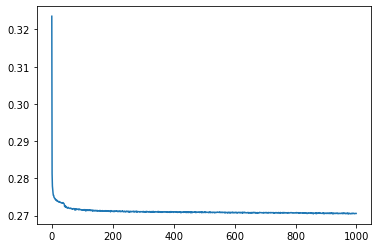

In [24]:
plt.plot(history)

Видим, что начиная с примерно 100 эпохи модель предсказывает нестабильно. Примерно на 900 эпохе ошибка выравнивается - имеет смысл увеличить число эпох до 1200 в следующий раз.

Попробуем подбирать другой гиперпараметр - число нейронов во 2 слое

In [41]:
best_last_error = np.inf
best_alg = activation_alias[0]
h_best = []
h_neurons = {}

for i in range(1, 100, 5):
    model = Sequential()
    model.add(Dense(2, input_dim=X_train.shape[1], activation='softsign'))
    model.add(Dense(i, activation='softsign'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('Num neurons: {}'.format(i))
    %time history = model.fit(X_train, y_train, batch_size=int(X_train.shape[0] / 10), epochs=100).history['loss']
    print()
    h_neurons[i] = history
    last_error = history[-1]
    if best_last_error > last_error:
        best_last_error = last_error
        best_n_neurons = i
        h_best = history

Num neurons: 1
Epoch 1/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.6683
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.7864
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6346 - accuracy: 0.8526
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6172 - accuracy: 0.8786
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6019 - accuracy: 0.8831
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5868 - accuracy: 0.8865
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5724 - accuracy: 0.8878
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5597 - accuracy: 0.8869
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5468 - accuracy: 0.8881
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5362 - accuracy: 0

11/11 [==============================] - 0s 2ms/step - loss: 0.3173 - accuracy: 0.8874
Epoch 83/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3141 - accuracy: 0.8888
Epoch 84/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.8892
Epoch 85/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3107 - accuracy: 0.8921
Epoch 86/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3090 - accuracy: 0.8922
Epoch 87/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8934
Epoch 88/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.8944
Epoch 89/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3093 - accuracy: 0.8935
Epoch 90/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3086 - accuracy: 0.8919
Epoch 91/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3046 - accuracy: 0.8950
Epoch 92/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2816 - accuracy: 0.8966
Epoch 64/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2798 - accuracy: 0.8973
Epoch 65/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2764 - accuracy: 0.9004
Epoch 66/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2766 - accuracy: 0.8992
Epoch 67/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2818 - accuracy: 0.8970
Epoch 68/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.8981
Epoch 69/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2797 - accuracy: 0.8982
Epoch 70/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2791 - accuracy: 0.9005
Epoch 71/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2778 - accuracy: 0.8994
Epoch 72/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.8990
Epoch 73/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2931 - accuracy: 0.8963
Epoch 45/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2912 - accuracy: 0.8971
Epoch 46/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2872 - accuracy: 0.8978
Epoch 47/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2880 - accuracy: 0.8982
Epoch 48/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2899 - accuracy: 0.8967
Epoch 49/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2875 - accuracy: 0.8974
Epoch 50/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2840 - accuracy: 0.8993
Epoch 51/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2834 - accuracy: 0.8983
Epoch 52/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2885 - accuracy: 0.8968
Epoch 53/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2886 - accuracy: 0.8966
Epoch 54/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2891 - accuracy: 0.8979
Epoch 26/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2928 - accuracy: 0.8943
Epoch 27/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2919 - accuracy: 0.8942
Epoch 28/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2938 - accuracy: 0.8937
Epoch 29/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2900 - accuracy: 0.8963
Epoch 30/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2889 - accuracy: 0.8963
Epoch 31/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.8976
Epoch 32/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2892 - accuracy: 0.8965
Epoch 33/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2834 - accuracy: 0.8993
Epoch 34/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2869 - accuracy: 0.8968
Epoch 35/100


11/11 [==============================] - 0s 2ms/step - loss: 0.4593 - accuracy: 0.8848
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4252 - accuracy: 0.8867
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3911 - accuracy: 0.8878
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3672 - accuracy: 0.8867
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3470 - accuracy: 0.8873
Epoch 11/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3382 - accuracy: 0.8866
Epoch 12/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3238 - accuracy: 0.8901
Epoch 13/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3196 - accuracy: 0.8897
Epoch 14/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3119 - accuracy: 0.8913
Epoch 15/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3155 - accuracy: 0.8874
Epoch 16/100
11/

11/11 [==============================] - 0s 2ms/step - loss: 0.2766 - accuracy: 0.8998
Epoch 89/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2777 - accuracy: 0.9000
Epoch 90/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.8994
Epoch 91/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2811 - accuracy: 0.8987
Epoch 92/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2817 - accuracy: 0.8987
Epoch 93/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2800 - accuracy: 0.8994
Epoch 94/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2810 - accuracy: 0.8976
Epoch 95/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2774 - accuracy: 0.9002
Epoch 96/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2805 - accuracy: 0.8988
Epoch 97/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2756 - accuracy: 0.9000
Epoch 98/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2770 - accuracy: 0.8994
Epoch 70/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2780 - accuracy: 0.8994
Epoch 71/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.8999
Epoch 72/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2789 - accuracy: 0.8994
Epoch 73/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2846 - accuracy: 0.8984
Epoch 74/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.8997
Epoch 75/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2794 - accuracy: 0.8998
Epoch 76/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2794 - accuracy: 0.9000
Epoch 77/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2801 - accuracy: 0.8995
Epoch 78/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2839 - accuracy: 0.8969
Epoch 79/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2847 - accuracy: 0.8981
Epoch 51/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2817 - accuracy: 0.8988
Epoch 52/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2903 - accuracy: 0.8955
Epoch 53/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2921 - accuracy: 0.8949
Epoch 54/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2867 - accuracy: 0.8977
Epoch 55/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2827 - accuracy: 0.8981
Epoch 56/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2838 - accuracy: 0.8985
Epoch 57/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2810 - accuracy: 0.8994
Epoch 58/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2853 - accuracy: 0.8963
Epoch 59/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2866 - accuracy: 0.8947
Epoch 60/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2957 - accuracy: 0.8961
Epoch 32/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.8965
Epoch 33/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2997 - accuracy: 0.8933
Epoch 34/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2939 - accuracy: 0.8964
Epoch 35/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2936 - accuracy: 0.8968
Epoch 36/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2902 - accuracy: 0.8989
Epoch 37/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2884 - accuracy: 0.8982
Epoch 38/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2950 - accuracy: 0.8955
Epoch 39/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2920 - accuracy: 0.8963
Epoch 40/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2887 - accuracy: 0.8972
Epoch 41/100


11/11 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.8939
Epoch 13/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3092 - accuracy: 0.8931
Epoch 14/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8937
Epoch 15/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3062 - accuracy: 0.8937
Epoch 16/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3052 - accuracy: 0.8942
Epoch 17/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.8958
Epoch 18/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2986 - accuracy: 0.8956
Epoch 19/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2986 - accuracy: 0.8957
Epoch 20/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2997 - accuracy: 0.8951
Epoch 21/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2932 - accuracy: 0.8978
Epoch 22/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2799 - accuracy: 0.8993
Epoch 95/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.9003
Epoch 96/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2808 - accuracy: 0.8991
Epoch 97/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2785 - accuracy: 0.8997
Epoch 98/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2759 - accuracy: 0.8995
Epoch 99/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2763 - accuracy: 0.9004
Epoch 100/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2785 - accuracy: 0.8987
Wall time: 2.99 s

Num neurons: 46
Epoch 1/100
11/11 [==============================] - 0s 2ms/step - loss: 0.7140 - accuracy: 0.3172
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6265 - accuracy: 0.8895
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5589

11/11 [==============================] - 0s 2ms/step - loss: 0.2822 - accuracy: 0.8979
Epoch 76/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2796 - accuracy: 0.8986
Epoch 77/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.8987
Epoch 78/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2787 - accuracy: 0.8986
Epoch 79/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2725 - accuracy: 0.9008
Epoch 80/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2793 - accuracy: 0.8986
Epoch 81/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.8992
Epoch 82/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2723 - accuracy: 0.9006
Epoch 83/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 0.9011
Epoch 84/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2772 - accuracy: 0.9001
Epoch 85/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2837 - accuracy: 0.8957
Epoch 57/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.8972
Epoch 58/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2829 - accuracy: 0.8970
Epoch 59/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.8957
Epoch 60/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2797 - accuracy: 0.8977
Epoch 61/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2801 - accuracy: 0.8977
Epoch 62/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2813 - accuracy: 0.8972
Epoch 63/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2800 - accuracy: 0.8971
Epoch 64/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.8978
Epoch 65/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2805 - accuracy: 0.9000
Epoch 66/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2866 - accuracy: 0.8944
Epoch 38/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2853 - accuracy: 0.8959
Epoch 39/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2803 - accuracy: 0.8981
Epoch 40/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2849 - accuracy: 0.8958
Epoch 41/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.8939
Epoch 42/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2788 - accuracy: 0.8971
Epoch 43/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2852 - accuracy: 0.8952
Epoch 44/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2837 - accuracy: 0.8941
Epoch 45/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2802 - accuracy: 0.8973
Epoch 46/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2878 - accuracy: 0.8947
Epoch 47/100


11/11 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.8961
Epoch 19/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3070 - accuracy: 0.8965
Epoch 20/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.8958
Epoch 21/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3057 - accuracy: 0.8969
Epoch 22/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3011 - accuracy: 0.8986
Epoch 23/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3002 - accuracy: 0.8980
Epoch 24/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2996 - accuracy: 0.8980
Epoch 25/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2977 - accuracy: 0.8983
Epoch 26/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2941 - accuracy: 0.8989
Epoch 27/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2964 - accuracy: 0.8976
Epoch 28/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2780 - accuracy: 0.8977
Wall time: 3.45 s

Num neurons: 66
Epoch 1/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.5142
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.8882
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.8862
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.8885
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3883 - accuracy: 0.8870
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3654 - accuracy: 0.8884
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3456 - accuracy: 0.8871
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3311 - accuracy: 0.8862
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3178 - accu

11/11 [==============================] - 0s 4ms/step - loss: 0.2861 - accuracy: 0.8949
Epoch 82/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2801 - accuracy: 0.8975
Epoch 83/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2797 - accuracy: 0.8981
Epoch 84/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2801 - accuracy: 0.8964
Epoch 85/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2807 - accuracy: 0.8990
Epoch 86/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2839 - accuracy: 0.8960
Epoch 87/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2831 - accuracy: 0.8986
Epoch 88/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2846 - accuracy: 0.8995
Epoch 89/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2838 - accuracy: 0.8984
Epoch 90/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2796 - accuracy: 0.8986
Epoch 91/100


11/11 [==============================] - 0s 3ms/step - loss: 0.2815 - accuracy: 0.8985
Epoch 63/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2756 - accuracy: 0.9003
Epoch 64/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2822 - accuracy: 0.8979
Epoch 65/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2770 - accuracy: 0.9007
Epoch 66/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2784 - accuracy: 0.8995
Epoch 67/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2828 - accuracy: 0.8981
Epoch 68/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2782 - accuracy: 0.8999
Epoch 69/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2787 - accuracy: 0.8990
Epoch 70/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2810 - accuracy: 0.8988
Epoch 71/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 0.8995
Epoch 72/100


11/11 [==============================] - 0s 3ms/step - loss: 0.2922 - accuracy: 0.8912
Epoch 44/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2931 - accuracy: 0.8923
Epoch 45/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2964 - accuracy: 0.8920
Epoch 46/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2884 - accuracy: 0.8956
Epoch 47/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2902 - accuracy: 0.8953
Epoch 48/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2967 - accuracy: 0.8921
Epoch 49/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2895 - accuracy: 0.8941
Epoch 50/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2928 - accuracy: 0.8928
Epoch 51/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2891 - accuracy: 0.8939
Epoch 52/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2907 - accuracy: 0.8929
Epoch 53/100


11/11 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.8984
Epoch 25/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2875 - accuracy: 0.8979
Epoch 26/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2879 - accuracy: 0.8971
Epoch 27/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2896 - accuracy: 0.8959
Epoch 28/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2838 - accuracy: 0.8986
Epoch 29/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2851 - accuracy: 0.8972
Epoch 30/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2865 - accuracy: 0.8966
Epoch 31/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2846 - accuracy: 0.8981
Epoch 32/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2829 - accuracy: 0.8987
Epoch 33/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2851 - accuracy: 0.8971
Epoch 34/100


11/11 [==============================] - 0s 3ms/step - loss: 0.3997 - accuracy: 0.8880
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3627 - accuracy: 0.8892
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3436 - accuracy: 0.8899
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3391 - accuracy: 0.8877
Epoch 9/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.8888
Epoch 10/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3295 - accuracy: 0.8861
Epoch 11/100
11/11 [==============================] - 0s 4ms/step - loss: 0.3207 - accuracy: 0.8887
Epoch 12/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3177 - accuracy: 0.8893
Epoch 13/100
11/11 [==============================] - 0s 4ms/step - loss: 0.3156 - accuracy: 0.8884
Epoch 14/100
11/11 [==============================] - 0s 4ms/step - loss: 0.3118 - accuracy: 0.8900
Epoch 15/100
11/1

11/11 [==============================] - 0s 3ms/step - loss: 0.2790 - accuracy: 0.8978
Epoch 88/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2822 - accuracy: 0.8972
Epoch 89/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2816 - accuracy: 0.8969
Epoch 90/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2814 - accuracy: 0.8969
Epoch 91/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2831 - accuracy: 0.8970
Epoch 92/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2826 - accuracy: 0.8973
Epoch 93/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2812 - accuracy: 0.8974
Epoch 94/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.8960
Epoch 95/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2790 - accuracy: 0.8979
Epoch 96/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2824 - accuracy: 0.8955
Epoch 97/100


11/11 [==============================] - 0s 3ms/step - loss: 0.2875 - accuracy: 0.8954
Epoch 69/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2869 - accuracy: 0.8939
Epoch 70/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2829 - accuracy: 0.8972
Epoch 71/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2853 - accuracy: 0.8947
Epoch 72/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2834 - accuracy: 0.8956
Epoch 73/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2841 - accuracy: 0.8959
Epoch 74/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2852 - accuracy: 0.8955
Epoch 75/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2815 - accuracy: 0.8955
Epoch 76/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.8954
Epoch 77/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2811 - accuracy: 0.8983
Epoch 78/100


11/11 [==============================] - 0s 4ms/step - loss: 0.2821 - accuracy: 0.8992
Epoch 50/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2857 - accuracy: 0.8979
Epoch 51/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2794 - accuracy: 0.8996
Epoch 52/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2799 - accuracy: 0.8982
Epoch 53/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2800 - accuracy: 0.8987
Epoch 54/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2767 - accuracy: 0.8997
Epoch 55/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2862 - accuracy: 0.8927
Epoch 56/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2952 - accuracy: 0.8870
Epoch 57/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2867 - accuracy: 0.8940
Epoch 58/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2792 - accuracy: 0.8993
Epoch 59/100


Выведем лучшие параметры

In [44]:
best_last_error

0.2772263288497925

In [45]:
best_n_neurons

6

Повторим тренировку с большей точностью

In [46]:
best_last_error = np.inf
best_alg = activation_alias[0]
h_best = []
h_neurons = {}

for i in range(10):
    model = Sequential()
    model.add(Dense(2, input_dim=X_train.shape[1], activation='softsign'))
    model.add(Dense(i, activation='softsign'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('Num neurons: {}'.format(i))
    %time history = model.fit(X_train, y_train, batch_size=int(X_train.shape[0] / 10), epochs=100).history['loss']
    print()
    h_neurons[i] = history
    last_error = history[-1]
    if best_last_error > last_error:
        best_last_error = last_error
        best_n_neurons = i
        h_best = history

Num neurons: 0
Epoch 1/100
11/11 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.8885
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8851
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8877
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8868
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8841
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8870
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8872
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8875
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8870
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0

11/11 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.8882
Epoch 83/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8870
Epoch 84/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8856
Epoch 85/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8863
Epoch 86/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8895
Epoch 87/100
11/11 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.8895
Epoch 88/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.8869
Epoch 89/100
11/11 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.8909
Epoch 90/100
11/11 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.8856
Epoch 91/100
11/11 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.8863
Epoch 92/100


11/11 [==============================] - 0s 3ms/step - loss: 0.3024 - accuracy: 0.8960
Epoch 64/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3030 - accuracy: 0.8954
Epoch 65/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3021 - accuracy: 0.8960
Epoch 66/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2980 - accuracy: 0.8972
Epoch 67/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3011 - accuracy: 0.8947
Epoch 68/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2976 - accuracy: 0.8973
Epoch 69/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2978 - accuracy: 0.8962
Epoch 70/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2970 - accuracy: 0.8975
Epoch 71/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2984 - accuracy: 0.8956
Epoch 72/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3008 - accuracy: 0.8950
Epoch 73/100


11/11 [==============================] - 0s 1ms/step - loss: 0.3457 - accuracy: 0.8932
Epoch 45/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3418 - accuracy: 0.8952
Epoch 46/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3408 - accuracy: 0.8950
Epoch 47/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3383 - accuracy: 0.8964
Epoch 48/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3412 - accuracy: 0.8934
Epoch 49/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3341 - accuracy: 0.8982
Epoch 50/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3353 - accuracy: 0.8969
Epoch 51/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3311 - accuracy: 0.8988
Epoch 52/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3305 - accuracy: 0.8993
Epoch 53/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3319 - accuracy: 0.8975
Epoch 54/100


11/11 [==============================] - 0s 3ms/step - loss: 0.3645 - accuracy: 0.8981
Epoch 26/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.8965
Epoch 27/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3577 - accuracy: 0.8971
Epoch 28/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.8982
Epoch 29/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3488 - accuracy: 0.8981
Epoch 30/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3454 - accuracy: 0.8985
Epoch 31/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3434 - accuracy: 0.8975
Epoch 32/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3383 - accuracy: 0.9001
Epoch 33/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3398 - accuracy: 0.8984
Epoch 34/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.8977
Epoch 35/100


11/11 [==============================] - 0s 2ms/step - loss: 0.5409 - accuracy: 0.8692
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5138 - accuracy: 0.8834
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.8915
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4638 - accuracy: 0.8941
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4417 - accuracy: 0.8962
Epoch 11/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4246 - accuracy: 0.8947
Epoch 12/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4093 - accuracy: 0.8948
Epoch 13/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3942 - accuracy: 0.8955
Epoch 14/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3814 - accuracy: 0.8967
Epoch 15/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3725 - accuracy: 0.8959
Epoch 16/100
11/

11/11 [==============================] - 0s 1ms/step - loss: 0.2835 - accuracy: 0.8962
Epoch 89/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2819 - accuracy: 0.8970
Epoch 90/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2805 - accuracy: 0.8981
Epoch 91/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2814 - accuracy: 0.8970
Epoch 92/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2814 - accuracy: 0.8977
Epoch 93/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2804 - accuracy: 0.8976
Epoch 94/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2845 - accuracy: 0.8956
Epoch 95/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2782 - accuracy: 0.8995
Epoch 96/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2790 - accuracy: 0.8981
Epoch 97/100
11/11 [==============================] - 0s 1ms/step - loss: 0.2825 - accuracy: 0.8969
Epoch 98/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2903 - accuracy: 0.8934
Epoch 70/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2904 - accuracy: 0.8944
Epoch 71/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2884 - accuracy: 0.8954
Epoch 72/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.8983
Epoch 73/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2834 - accuracy: 0.8987
Epoch 74/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2846 - accuracy: 0.8978
Epoch 75/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2815 - accuracy: 0.8988
Epoch 76/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2818 - accuracy: 0.8993
Epoch 77/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.8998
Epoch 78/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.8969
Epoch 79/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2940 - accuracy: 0.8948
Epoch 51/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2883 - accuracy: 0.8977
Epoch 52/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2884 - accuracy: 0.8972
Epoch 53/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2942 - accuracy: 0.8941
Epoch 54/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2887 - accuracy: 0.8968
Epoch 55/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2878 - accuracy: 0.8979
Epoch 56/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2870 - accuracy: 0.8978
Epoch 57/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2892 - accuracy: 0.8966
Epoch 58/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2906 - accuracy: 0.8967
Epoch 59/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2930 - accuracy: 0.8941
Epoch 60/100


11/11 [==============================] - 0s 3ms/step - loss: 0.2979 - accuracy: 0.8990
Epoch 32/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2945 - accuracy: 0.8993
Epoch 33/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2946 - accuracy: 0.8988
Epoch 34/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2958 - accuracy: 0.8984
Epoch 35/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2948 - accuracy: 0.8986
Epoch 36/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2954 - accuracy: 0.8980
Epoch 37/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2925 - accuracy: 0.8978
Epoch 38/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2934 - accuracy: 0.8972
Epoch 39/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2921 - accuracy: 0.8980
Epoch 40/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2932 - accuracy: 0.8970
Epoch 41/100


11/11 [==============================] - 0s 2ms/step - loss: 0.3607 - accuracy: 0.8929
Epoch 13/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3483 - accuracy: 0.8948
Epoch 14/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8947
Epoch 15/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3375 - accuracy: 0.8931
Epoch 16/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3326 - accuracy: 0.8935
Epoch 17/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3274 - accuracy: 0.8944
Epoch 18/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3224 - accuracy: 0.8954
Epoch 19/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3212 - accuracy: 0.8946
Epoch 20/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3182 - accuracy: 0.8961
Epoch 21/100
11/11 [==============================] - 0s 1ms/step - loss: 0.3162 - accuracy: 0.8959
Epoch 22/100


11/11 [==============================] - 0s 2ms/step - loss: 0.2827 - accuracy: 0.8971
Epoch 94/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2889 - accuracy: 0.8938
Epoch 95/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2838 - accuracy: 0.8953
Epoch 96/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2832 - accuracy: 0.8969
Epoch 97/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2806 - accuracy: 0.8976
Epoch 98/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2871 - accuracy: 0.8956
Epoch 99/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2880 - accuracy: 0.8959
Epoch 100/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2793 - accuracy: 0.8991
Wall time: 2.24 s

Num neurons: 9
Epoch 1/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6716 - accuracy: 0.6109
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6310

11/11 [==============================] - 0s 2ms/step - loss: 0.2783 - accuracy: 0.8994
Epoch 75/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2824 - accuracy: 0.8974
Epoch 76/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2774 - accuracy: 0.8994
Epoch 77/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2770 - accuracy: 0.9004
Epoch 78/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2866 - accuracy: 0.8946
Epoch 79/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2813 - accuracy: 0.8972
Epoch 80/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2815 - accuracy: 0.8959
Epoch 81/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2773 - accuracy: 0.9006
Epoch 82/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2845 - accuracy: 0.8982
Epoch 83/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2781 - accuracy: 0.9004
Epoch 84/100


Выведем лучшие параметры

In [47]:
best_last_error

0.2800201177597046

In [48]:
best_n_neurons

7

Зафиксирум число нейронов во 2 слое, равным 7

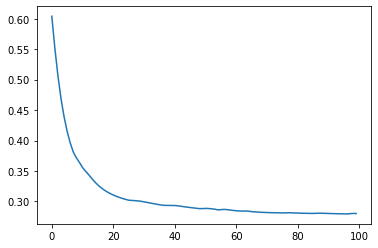

In [50]:
plt.plot(h_best)

Визуализируем данные при различном числе нейронов

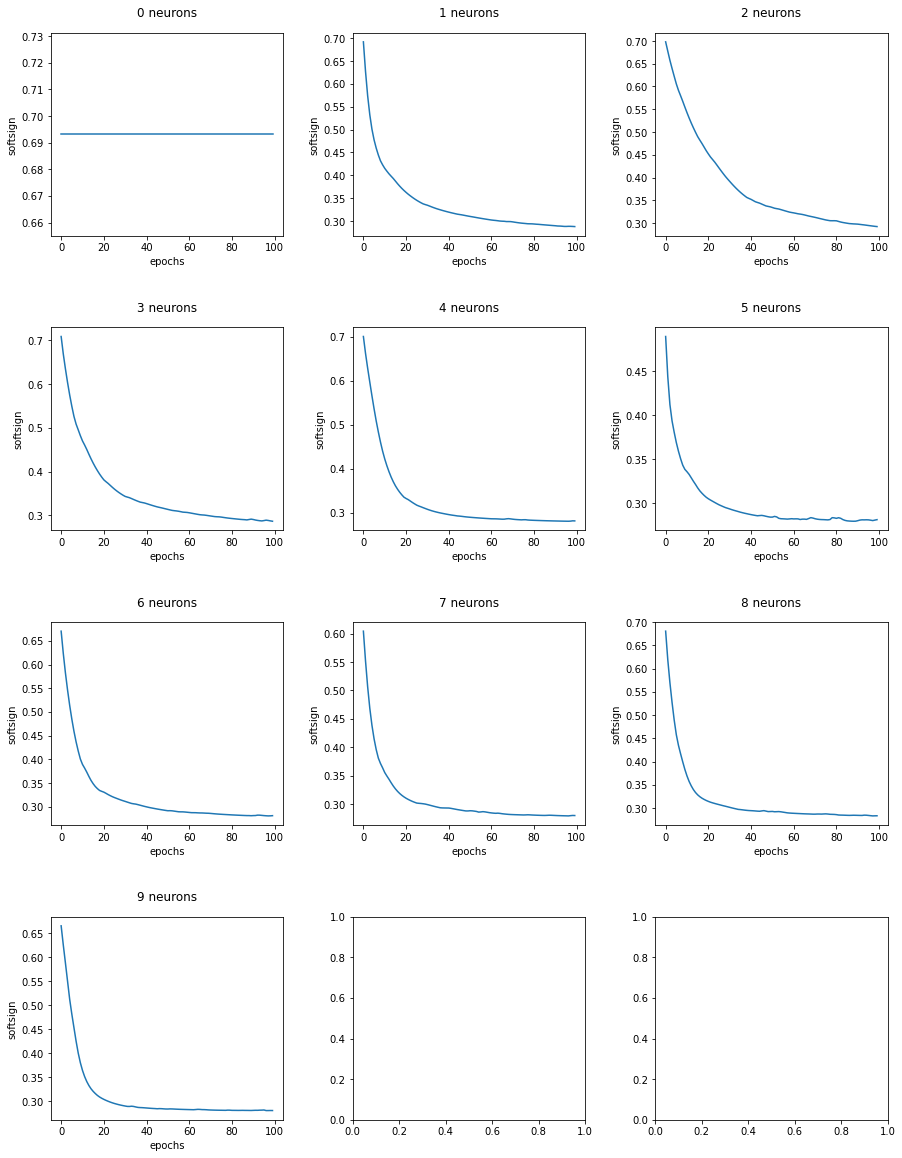

In [52]:
fig, axes = plt.subplots(nrows=(len(h_neurons) + 2)//3, ncols=3, figsize=(15, 20))
axes = axes.reshape(3 * ((len(h_neurons) + 2)//3))

for i, n_neurons in enumerate(h_neurons):
    axes[i].plot(range(len(h_neurons[n_neurons])), h_neurons[n_neurons])
    axes[i].set_xlabel('epochs')
    axes[i].set_ylabel('softsign')
    axes[i].set_title('{} neurons'.format(n_neurons), pad=16)
# Увелчиваем расстояние между графиками
plt.subplots_adjust(wspace=0.3, hspace=0.45)

Будем тренировать модель на функции активации softsign с 7 нейронами во 2 слое и 1200 эпох

In [53]:
model_best = Sequential()
model_best.add(Dense(2, input_dim=X_train.shape[1], activation='softsign'))
model_best.add(Dense(7, activation='softsign'))
model_best.add(Dense(2, activation='softmax'))

model_best.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Algorytm: {}', best_alg)
%time history = model_best.fit(X_train, y_train, epochs=1200).history['loss']
error = history[-1]

y_pred = np.argmax(model_best.predict(X_test), axis=1)
print_score(y_test, y_pred)

Algorytm: {} relu
Epoch 1/1200
966/966 [==============================] - 1s 557us/step - loss: 0.3629 - accuracy: 0.8749
Epoch 2/1200
966/966 [==============================] - 1s 561us/step - loss: 0.2772 - accuracy: 0.8985
Epoch 3/1200
966/966 [==============================] - 1s 556us/step - loss: 0.2749 - accuracy: 0.9006
Epoch 4/1200
966/966 [==============================] - 1s 550us/step - loss: 0.2776 - accuracy: 0.8984
Epoch 5/1200
966/966 [==============================] - 1s 557us/step - loss: 0.2744 - accuracy: 0.8995
Epoch 6/1200
966/966 [==============================] - 1s 544us/step - loss: 0.2746 - accuracy: 0.9001
Epoch 7/1200
966/966 [==============================] - 1s 676us/step - loss: 0.2750 - accuracy: 0.9001
Epoch 8/1200
966/966 [==============================] - 1s 566us/step - loss: 0.2757 - accuracy: 0.9004
Epoch 9/1200
966/966 [==============================] - 1s 560us/step - loss: 0.2721 - accuracy: 0.9022
Epoch 10/1200
966/966 [=======================

Epoch 79/1200
966/966 [==============================] - 0s 513us/step - loss: 0.2781 - accuracy: 0.8991
Epoch 80/1200
966/966 [==============================] - 0s 515us/step - loss: 0.2793 - accuracy: 0.8965
Epoch 81/1200
966/966 [==============================] - 0s 515us/step - loss: 0.2722 - accuracy: 0.9016
Epoch 82/1200
966/966 [==============================] - 0s 508us/step - loss: 0.2707 - accuracy: 0.9019
Epoch 83/1200
966/966 [==============================] - 1s 522us/step - loss: 0.2680 - accuracy: 0.9047
Epoch 84/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2681 - accuracy: 0.9042
Epoch 85/1200
966/966 [==============================] - 1s 540us/step - loss: 0.2707 - accuracy: 0.9021
Epoch 86/1200
966/966 [==============================] - 1s 519us/step - loss: 0.2707 - accuracy: 0.9029
Epoch 87/1200
966/966 [==============================] - 1s 533us/step - loss: 0.2717 - accuracy: 0.9040
Epoch 88/1200
966/966 [==============================] 

966/966 [==============================] - 1s 519us/step - loss: 0.2747 - accuracy: 0.9006
Epoch 157/1200
966/966 [==============================] - 1s 518us/step - loss: 0.2711 - accuracy: 0.9032
Epoch 158/1200
966/966 [==============================] - 1s 548us/step - loss: 0.2730 - accuracy: 0.9018
Epoch 159/1200
966/966 [==============================] - 1s 521us/step - loss: 0.2690 - accuracy: 0.9031
Epoch 160/1200
966/966 [==============================] - 1s 535us/step - loss: 0.2742 - accuracy: 0.9019
Epoch 161/1200
966/966 [==============================] - 0s 512us/step - loss: 0.2703 - accuracy: 0.9040
Epoch 162/1200
966/966 [==============================] - 1s 519us/step - loss: 0.2679 - accuracy: 0.9036
Epoch 163/1200
966/966 [==============================] - 0s 506us/step - loss: 0.2695 - accuracy: 0.9047
Epoch 164/1200
966/966 [==============================] - 0s 512us/step - loss: 0.2697 - accuracy: 0.9027
Epoch 165/1200
966/966 [==============================] - 0s 

966/966 [==============================] - 1s 522us/step - loss: 0.2746 - accuracy: 0.9011
Epoch 234/1200
966/966 [==============================] - 1s 657us/step - loss: 0.2663 - accuracy: 0.9051
Epoch 235/1200
966/966 [==============================] - 1s 584us/step - loss: 0.2725 - accuracy: 0.9039
Epoch 236/1200
966/966 [==============================] - 1s 759us/step - loss: 0.2706 - accuracy: 0.9020
Epoch 237/1200
966/966 [==============================] - 1s 740us/step - loss: 0.2707 - accuracy: 0.9037
Epoch 238/1200
966/966 [==============================] - 1s 829us/step - loss: 0.2735 - accuracy: 0.9017
Epoch 239/1200
966/966 [==============================] - 1s 851us/step - loss: 0.2752 - accuracy: 0.9011
Epoch 240/1200
966/966 [==============================] - 1s 544us/step - loss: 0.2723 - accuracy: 0.9021
Epoch 241/1200
966/966 [==============================] - 1s 713us/step - loss: 0.2744 - accuracy: 0.9025
Epoch 242/1200
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 523us/step - loss: 0.2752 - accuracy: 0.9012
Epoch 311/1200
966/966 [==============================] - 1s 543us/step - loss: 0.2700 - accuracy: 0.9023
Epoch 312/1200
966/966 [==============================] - 1s 545us/step - loss: 0.2686 - accuracy: 0.9034
Epoch 313/1200
966/966 [==============================] - 1s 542us/step - loss: 0.2700 - accuracy: 0.9032
Epoch 314/1200
966/966 [==============================] - 0s 512us/step - loss: 0.2701 - accuracy: 0.9044
Epoch 315/1200
966/966 [==============================] - 0s 513us/step - loss: 0.2645 - accuracy: 0.9044
Epoch 316/1200
966/966 [==============================] - 0s 514us/step - loss: 0.2677 - accuracy: 0.9058
Epoch 317/1200
966/966 [==============================] - 1s 522us/step - loss: 0.2683 - accuracy: 0.9045
Epoch 318/1200
966/966 [==============================] - 0s 512us/step - loss: 0.2716 - accuracy: 0.9037
Epoch 319/1200
966/966 [==============================] - 0s 

966/966 [==============================] - 1s 541us/step - loss: 0.2712 - accuracy: 0.9053
Epoch 388/1200
966/966 [==============================] - 1s 524us/step - loss: 0.2683 - accuracy: 0.9044
Epoch 389/1200
966/966 [==============================] - 1s 520us/step - loss: 0.2683 - accuracy: 0.9048
Epoch 390/1200
966/966 [==============================] - 0s 516us/step - loss: 0.2706 - accuracy: 0.9034
Epoch 391/1200
966/966 [==============================] - 1s 537us/step - loss: 0.2704 - accuracy: 0.9046
Epoch 392/1200
966/966 [==============================] - 1s 546us/step - loss: 0.2738 - accuracy: 0.9033
Epoch 393/1200
966/966 [==============================] - 0s 517us/step - loss: 0.2723 - accuracy: 0.9024
Epoch 394/1200
966/966 [==============================] - 0s 511us/step - loss: 0.2750 - accuracy: 0.9031
Epoch 395/1200
966/966 [==============================] - 1s 521us/step - loss: 0.2601 - accuracy: 0.9095
Epoch 396/1200
966/966 [==============================] - 1s 

966/966 [==============================] - 0s 507us/step - loss: 0.2687 - accuracy: 0.9045
Epoch 465/1200
966/966 [==============================] - 0s 515us/step - loss: 0.2718 - accuracy: 0.9040
Epoch 466/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2698 - accuracy: 0.9032
Epoch 467/1200
966/966 [==============================] - 0s 508us/step - loss: 0.2686 - accuracy: 0.9037
Epoch 468/1200
966/966 [==============================] - 0s 508us/step - loss: 0.2655 - accuracy: 0.9059
Epoch 469/1200
966/966 [==============================] - 0s 511us/step - loss: 0.2674 - accuracy: 0.9046
Epoch 470/1200
966/966 [==============================] - 1s 523us/step - loss: 0.2708 - accuracy: 0.9045
Epoch 471/1200
966/966 [==============================] - 1s 521us/step - loss: 0.2715 - accuracy: 0.9033
Epoch 472/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2723 - accuracy: 0.9022
Epoch 473/1200
966/966 [==============================] - 1s 

966/966 [==============================] - 0s 505us/step - loss: 0.2672 - accuracy: 0.9059
Epoch 542/1200
966/966 [==============================] - 0s 506us/step - loss: 0.2695 - accuracy: 0.9034
Epoch 543/1200
966/966 [==============================] - 0s 505us/step - loss: 0.2735 - accuracy: 0.9026
Epoch 544/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2696 - accuracy: 0.9053
Epoch 545/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2735 - accuracy: 0.9023
Epoch 546/1200
966/966 [==============================] - 0s 516us/step - loss: 0.2697 - accuracy: 0.9049
Epoch 547/1200
966/966 [==============================] - 0s 508us/step - loss: 0.2698 - accuracy: 0.9048
Epoch 548/1200
966/966 [==============================] - 0s 505us/step - loss: 0.2777 - accuracy: 0.9024
Epoch 549/1200
966/966 [==============================] - 1s 525us/step - loss: 0.2743 - accuracy: 0.9027
Epoch 550/1200
966/966 [==============================] - 1s 

966/966 [==============================] - 0s 504us/step - loss: 0.2686 - accuracy: 0.9045
Epoch 619/1200
966/966 [==============================] - 0s 505us/step - loss: 0.2687 - accuracy: 0.9057
Epoch 620/1200
966/966 [==============================] - 0s 509us/step - loss: 0.2762 - accuracy: 0.9014
Epoch 621/1200
966/966 [==============================] - 0s 508us/step - loss: 0.2735 - accuracy: 0.9033
Epoch 622/1200
966/966 [==============================] - 0s 506us/step - loss: 0.2661 - accuracy: 0.9058
Epoch 623/1200
966/966 [==============================] - 0s 511us/step - loss: 0.2727 - accuracy: 0.9022
Epoch 624/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2708 - accuracy: 0.9040
Epoch 625/1200
966/966 [==============================] - 0s 507us/step - loss: 0.2741 - accuracy: 0.9022
Epoch 626/1200
966/966 [==============================] - 0s 511us/step - loss: 0.2704 - accuracy: 0.9041
Epoch 627/1200
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 518us/step - loss: 0.2761 - accuracy: 0.9013
Epoch 696/1200
966/966 [==============================] - 0s 515us/step - loss: 0.2719 - accuracy: 0.9040
Epoch 697/1200
966/966 [==============================] - 1s 533us/step - loss: 0.2717 - accuracy: 0.9055
Epoch 698/1200
966/966 [==============================] - 1s 529us/step - loss: 0.2711 - accuracy: 0.9029
Epoch 699/1200
966/966 [==============================] - 0s 512us/step - loss: 0.2682 - accuracy: 0.9056
Epoch 700/1200
966/966 [==============================] - 1s 549us/step - loss: 0.2742 - accuracy: 0.9016
Epoch 701/1200
966/966 [==============================] - 0s 512us/step - loss: 0.2698 - accuracy: 0.9055
Epoch 702/1200
966/966 [==============================] - 0s 515us/step - loss: 0.2765 - accuracy: 0.9015
Epoch 703/1200
966/966 [==============================] - 1s 534us/step - loss: 0.2760 - accuracy: 0.9013
Epoch 704/1200
966/966 [==============================] - 1s 

966/966 [==============================] - 0s 515us/step - loss: 0.2757 - accuracy: 0.9001
Epoch 773/1200
966/966 [==============================] - 1s 522us/step - loss: 0.2717 - accuracy: 0.9038
Epoch 774/1200
966/966 [==============================] - 0s 512us/step - loss: 0.2664 - accuracy: 0.9057
Epoch 775/1200
966/966 [==============================] - 0s 511us/step - loss: 0.2684 - accuracy: 0.9048
Epoch 776/1200
966/966 [==============================] - 0s 514us/step - loss: 0.2711 - accuracy: 0.9047
Epoch 777/1200
966/966 [==============================] - 1s 535us/step - loss: 0.2682 - accuracy: 0.9051
Epoch 778/1200
966/966 [==============================] - 1s 529us/step - loss: 0.2659 - accuracy: 0.9067
Epoch 779/1200
966/966 [==============================] - 0s 515us/step - loss: 0.2788 - accuracy: 0.9009
Epoch 780/1200
966/966 [==============================] - 0s 514us/step - loss: 0.2649 - accuracy: 0.9064
Epoch 781/1200
966/966 [==============================] - 0s 

966/966 [==============================] - 0s 510us/step - loss: 0.2693 - accuracy: 0.9042
Epoch 850/1200
966/966 [==============================] - 0s 507us/step - loss: 0.2717 - accuracy: 0.9035
Epoch 851/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2701 - accuracy: 0.9058
Epoch 852/1200
966/966 [==============================] - 0s 514us/step - loss: 0.2749 - accuracy: 0.9012
Epoch 853/1200
966/966 [==============================] - 0s 508us/step - loss: 0.2717 - accuracy: 0.9028
Epoch 854/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2723 - accuracy: 0.9037
Epoch 855/1200
966/966 [==============================] - 1s 537us/step - loss: 0.2713 - accuracy: 0.9037
Epoch 856/1200
966/966 [==============================] - 1s 536us/step - loss: 0.2714 - accuracy: 0.9024
Epoch 857/1200
966/966 [==============================] - 1s 536us/step - loss: 0.2723 - accuracy: 0.9020
Epoch 858/1200
966/966 [==============================] - 1s 

966/966 [==============================] - 1s 538us/step - loss: 0.2740 - accuracy: 0.9021
Epoch 927/1200
966/966 [==============================] - 1s 573us/step - loss: 0.2659 - accuracy: 0.9071
Epoch 928/1200
966/966 [==============================] - 0s 511us/step - loss: 0.2668 - accuracy: 0.9069
Epoch 929/1200
966/966 [==============================] - 0s 508us/step - loss: 0.2695 - accuracy: 0.9049
Epoch 930/1200
966/966 [==============================] - 0s 513us/step - loss: 0.2676 - accuracy: 0.9051
Epoch 931/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2707 - accuracy: 0.9044
Epoch 932/1200
966/966 [==============================] - 0s 514us/step - loss: 0.2731 - accuracy: 0.9025
Epoch 933/1200
966/966 [==============================] - 0s 506us/step - loss: 0.2737 - accuracy: 0.9034
Epoch 934/1200
966/966 [==============================] - 0s 511us/step - loss: 0.2673 - accuracy: 0.9051
Epoch 935/1200
966/966 [==============================] - 0s 

966/966 [==============================] - 0s 506us/step - loss: 0.2702 - accuracy: 0.9053
Epoch 1004/1200
966/966 [==============================] - 1s 525us/step - loss: 0.2745 - accuracy: 0.9029
Epoch 1005/1200
966/966 [==============================] - 1s 533us/step - loss: 0.2733 - accuracy: 0.9034
Epoch 1006/1200
966/966 [==============================] - 1s 524us/step - loss: 0.2706 - accuracy: 0.9043
Epoch 1007/1200
966/966 [==============================] - 1s 531us/step - loss: 0.2684 - accuracy: 0.9056
Epoch 1008/1200
966/966 [==============================] - 1s 535us/step - loss: 0.2730 - accuracy: 0.9035
Epoch 1009/1200
966/966 [==============================] - 0s 505us/step - loss: 0.2705 - accuracy: 0.9046
Epoch 1010/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2687 - accuracy: 0.9044
Epoch 1011/1200
966/966 [==============================] - 0s 507us/step - loss: 0.2668 - accuracy: 0.9056
Epoch 1012/1200
966/966 [============================

966/966 [==============================] - 0s 507us/step - loss: 0.2651 - accuracy: 0.9068
Epoch 1080/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2669 - accuracy: 0.9058
Epoch 1081/1200
966/966 [==============================] - 0s 506us/step - loss: 0.2670 - accuracy: 0.9062
Epoch 1082/1200
966/966 [==============================] - 0s 517us/step - loss: 0.2633 - accuracy: 0.9085
Epoch 1083/1200
966/966 [==============================] - 0s 511us/step - loss: 0.2723 - accuracy: 0.9024
Epoch 1084/1200
966/966 [==============================] - 1s 520us/step - loss: 0.2691 - accuracy: 0.9046
Epoch 1085/1200
966/966 [==============================] - 0s 510us/step - loss: 0.2701 - accuracy: 0.9064
Epoch 1086/1200
966/966 [==============================] - 0s 512us/step - loss: 0.2640 - accuracy: 0.9071
Epoch 1087/1200
966/966 [==============================] - 0s 508us/step - loss: 0.2681 - accuracy: 0.9054
Epoch 1088/1200
966/966 [============================

966/966 [==============================] - 1s 716us/step - loss: 0.2695 - accuracy: 0.9060
Epoch 1156/1200
966/966 [==============================] - 1s 800us/step - loss: 0.2679 - accuracy: 0.9051
Epoch 1157/1200
966/966 [==============================] - 1s 534us/step - loss: 0.2747 - accuracy: 0.9019
Epoch 1158/1200
966/966 [==============================] - 1s 560us/step - loss: 0.2741 - accuracy: 0.9029
Epoch 1159/1200
966/966 [==============================] - 1s 622us/step - loss: 0.2683 - accuracy: 0.9048
Epoch 1160/1200
966/966 [==============================] - 1s 535us/step - loss: 0.2655 - accuracy: 0.9060
Epoch 1161/1200
966/966 [==============================] - 1s 592us/step - loss: 0.2707 - accuracy: 0.9048
Epoch 1162/1200
966/966 [==============================] - 1s 568us/step - loss: 0.2685 - accuracy: 0.9057
Epoch 1163/1200
966/966 [==============================] - 1s 531us/step - loss: 0.2625 - accuracy: 0.9083
Epoch 1164/1200
966/966 [============================

Посмотрим на точность данной модели

In [54]:
_, accuracy = model_best.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

322/322 [==============================] - 0s 477us/step - loss: 0.2798 - accuracy: 0.8999
Accuracy: 89.99


Точность 90% устраивает в данной модели.

# Сохранение модели

In [57]:
model_best.save('../keras_models/model1')

INFO:tensorflow:Assets written to: ../keras_models/model1\assets


INFO:tensorflow:Assets written to: ../keras_models/model1\assets


# Вывод

Был рассмотрен модуль keras. Произведен подбор гиперпараметров, сохранена лучшая модель
